# Dose Response (under construction)

This example generates a doseResponse plot for a bistable system, against
a control parameter (dose) that takes the system in and out again from the 
bistable regime. Like the previous example, it uses the steady-state solver 
to find the stable points for each value of the control parameter.
Unfortunately it doesn't work right now. Seems like the kcat scaling
isn't being registered.

scale=0.010	kcat=0.004
scale=0.013	kcat=0.005
scale=0.016	kcat=0.006
scale=0.020	kcat=0.007
scale=0.025	kcat=0.009
scale=0.032	kcat=0.011
scale=0.040	kcat=0.014
scale=0.050	kcat=0.018
scale=0.063	kcat=0.023
scale=0.079	kcat=0.029
scale=0.100	kcat=0.036
scale=0.126	kcat=0.045
scale=0.158	kcat=0.057
scale=0.200	kcat=0.072
scale=0.251	kcat=0.091
scale=0.316	kcat=0.114
scale=0.398	kcat=0.144
scale=0.501	kcat=0.181
scale=0.631	kcat=0.228
scale=0.794	kcat=0.287
scale=1.000	kcat=0.361
scale=1.259	kcat=0.454
scale=1.585	kcat=0.572
scale=1.995	kcat=0.720
scale=2.512	kcat=0.907
scale=3.162	kcat=1.142
scale=3.981	kcat=1.437
scale=5.012	kcat=1.809
scale=6.310	kcat=2.278
scale=7.943	kcat=2.868
scale=10.000	kcat=3.610
scale=12.589	kcat=4.545
scale=15.849	kcat=5.722
scale=19.953	kcat=7.203
scale=25.119	kcat=9.068
scale=31.623	kcat=11.416
scale=39.811	kcat=14.372
scale=50.119	kcat=18.093
scale=63.096	kcat=22.778
scale=79.433	kcat=28.676
scale=100.000	kcat=36.101


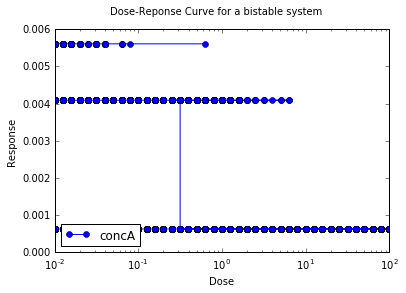

In [1]:
## Makes and plots the dose response curve for bistable models
## Author: Sahil Moza
## June 26, 2014

%matplotlib inline

import moose
import pylab
import numpy as np
from matplotlib import pyplot as plt

def setupSteadyState(simdt,plotDt):

    ksolve = moose.Ksolve( '/model/kinetics/ksolve' )
    stoich = moose.Stoich( '/model/kinetics/stoich' )
    stoich.compartment = moose.element('/model/kinetics')

    stoich.ksolve = ksolve
    #ksolve.stoich = stoich
    stoich.path = "/model/kinetics/##"
    state = moose.SteadyState( '/model/kinetics/state' )
   
    #### Set clocks here
    #moose.useClock(4, "/model/kinetics/##[]", "process")
    #moose.setClock(4, float(simdt))
    #moose.setClock(5, float(simdt))
    #moose.useClock(5, '/model/kinetics/ksolve', 'process' )
    #moose.useClock(8, '/model/graphs/#', 'process' )
    #moose.setClock(8, float(plotDt))
 
    moose.reinit()

    state.stoich = stoich
    state.showMatrices()
    state.convergenceCriterion = 1e-8
    
    return ksolve, state

def parseModelName(fileName):
    pos1=fileName.rfind('/')
    pos2=fileName.rfind('.')
    directory=fileName[:pos1]
    prefix=fileName[pos1+1:pos2]
    suffix=fileName[pos2+1:len(fileName)]
    return directory, prefix, suffix

# Solve for the steady state
def getState( ksolve, state, vol):
      scale = 1.0 / ( vol * 6.022e23 )
      moose.reinit
      state.randomInit() # Removing random initial condition to systematically make Dose reponse curves.
      moose.start( 2.0 ) # Run the model for 2 seconds.
      state.settle()
      
      vector = []
      a = moose.element( '/model/kinetics/a' ).conc
      for x in ksolve.nVec[0]:
          vector.append( x * scale)
      moose.start( 10.0 ) # Run model for 10 seconds, just for display
      failedSteadyState = any([np.isnan(x) for x in vector])
      
      if not (failedSteadyState):
           return state.stateType, state.solutionStatus, a, vector


def main():
    # Setup parameters for simulation and plotting
    simdt= 1e-2
    plotDt= 1

    # Factors to change in the dose concentration in log scale
    factorExponent = 10  ## Base: ten raised to some power.
    factorBegin = -20
    factorEnd = 21
    factorStepsize = 1
    factorScale = 10.0 ## To scale up or down the factors

    # Load Model and set up the steady state solver.
    # model = sys.argv[1] # To load model from a file.
    model = './19085.cspace'
    modelPath, modelName, modelType = parseModelName(model)
    outputDir = modelPath
    
    modelId = moose.loadModel(model, 'model', 'ee')
    dosePath = '/model/kinetics/b/DabX' # The dose entity

    ksolve, state = setupSteadyState( simdt, plotDt)
    vol = moose.element( '/model/kinetics' ).volume
    iterInit = 100
    solutionVector = []
    factorArr = []
    
    enz = moose.element(dosePath)
    init = enz.kcat # Dose parameter
    
    # Change Dose here to .
    for factor in range(factorBegin, factorEnd, factorStepsize ):
        scale = factorExponent ** (factor/factorScale) 
        enz.kcat = init * scale     
        print( "scale={:.3f}\tkcat={:.3f}".format( scale, enz.kcat) )
        for num in range(iterInit):
            stateType, solStatus, a, vector = getState( ksolve, state, vol)
            if solStatus == 0:
                #solutionVector.append(vector[0]/sum(vector))
                solutionVector.append(a)
                factorArr.append(scale)   
                
    joint = np.array([factorArr, solutionVector])
    joint = joint[:,joint[1,:].argsort()]
    
    # Plot dose response. 
    fig0 = plt.figure()
    pylab.semilogx(joint[0,:],joint[1,:],marker="o",label = 'concA')
    pylab.xlabel('Dose')
    pylab.ylabel('Response')
    pylab.suptitle('Dose-Reponse Curve for a bistable system')
    
    pylab.legend(loc=3)
    #plt.savefig(outputDir + "/" + modelName +"_doseResponse" + ".png")
    plt.show()
    #plt.close(fig0)
    quit()
    


if __name__ == '__main__':
     main()